# Hand-craft features to train an MLP on DEV
Features:
1. Number of overlapping unigrams
2. Word edit distance

In [1]:
import editdistance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from joblib import dump, load
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def load_dev_devtest(path):
    """
    calls word_tokenize
    returns first_lines, second_lines, labels
    """
    first_lines = []
    second_lines = []
    labels = []
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = word_tokenize(chunks[0])
            second = word_tokenize(chunks[1])
            label = int(chunks[2])
            first_lines.append(first)
            second_lines.append(second)
            labels.append(label)
    return first_lines, second_lines, labels

def load_test(path):
    """
    skip id column, calls word_tokenize
    """
    first_lines, second_lines = [], []
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = word_tokenize(chunks[1])
            second = word_tokenize(chunks[2])
            first_lines.append(first)
            second_lines.append(second)
    return first_lines, second_lines

def load_test_hard(path):
    """
    no id column, calls word_tokenize
    """
    first_lines, second_lines = [], []
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = word_tokenize(chunks[0])
            second = word_tokenize(chunks[1])
            first_lines.append(first)
            second_lines.append(second)
    return first_lines, second_lines

In [3]:
def construct_features(first_lines, second_lines):
    # number of overlapping unigrams, edit distance
    features = np.empty((len(first_lines), 2))
    for idx, tup in enumerate(zip(first_lines, second_lines)):
        first, second = tup
        num_unigrams = len(set(first).intersection(second))
        edit_dist = editdistance.eval(first, second)
        features[idx, 0] = num_unigrams
        features[idx, 1] = edit_dist
    return features

# MLP

## Non-hard

In [4]:
dev = load_dev_devtest('data/dev+devtest/dev.tsv')
devtest = load_dev_devtest('data/dev+devtest/devtest.tsv')
test = load_test('data/test_no_labels.tsv')

In [5]:
X = construct_features(dev[0], dev[1])
y = dev[2]

In [6]:
model = MLPClassifier(max_iter=1000, random_state=0)
model.fit(X, y)

MLPClassifier(max_iter=1000, random_state=0)

In [7]:
y_pred = model.predict(X)
'Train accuray: {:4f}'.format(accuracy_score(y, y_pred))

'Train accuray: 0.816626'

In [8]:
X_devtest = construct_features(devtest[0], devtest[1])
y_devtest = devtest[2]
y_pred = model.predict(X_devtest)
'Devtest accuray: {:4f}'.format(accuracy_score(y_devtest, y_pred))

'Devtest accuray: 0.792547'

Text(33.0, 0.5, 'True labels')

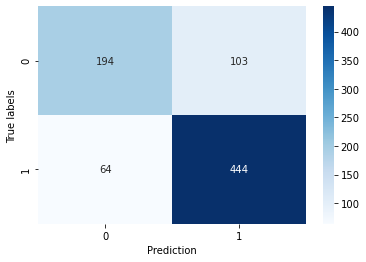

In [9]:
conf_mat = confusion_matrix(y_devtest, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Prediction')
ax.set_ylabel('True labels')

In [10]:
# dump(model, 'output/mlp.joblib') 

In [11]:
X_test = construct_features(test[0], test[1])
y_pred = model.predict(X_test)

In [12]:
submission = pd.DataFrame({
    'id': range(len(y_pred)),
    'Category': y_pred
})

In [13]:
# submission.to_csv('output/submission.csv', index=False)

## Hard

In [14]:
dev = load_dev_devtest('data/heldout-hard/dev.hard.tsv')
devtest= load_dev_devtest('data/heldout-hard/devtest.hard.tsv')
test = load_test_hard('data/heldout-hard/test.hard.tsv')

In [15]:
X = construct_features(dev[0], dev[1])
y = dev[2]
model = MLPClassifier(max_iter=1000, random_state=0)
model.fit(X, y)
y_pred = model.predict(X)
print('Train accuray: {:4f}'.format(accuracy_score(y, y_pred)))
X_devtest = construct_features(devtest[0], devtest[1])
y_devtest = devtest[2]
y_pred = model.predict(X_devtest)
print('Devtest accuray: {:4f}'.format(accuracy_score(y_devtest, y_pred)))

Train accuray: 0.668000
Devtest accuray: 0.648000


Text(33.0, 0.5, 'True labels')

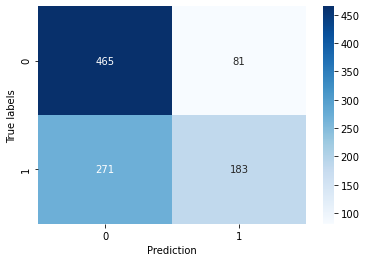

In [16]:
conf_mat = confusion_matrix(y_devtest, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Prediction')
ax.set_ylabel('True labels')

In [17]:
# dump(model, 'output/mlp-hard.joblib') 

In [18]:
X_test = construct_features(test[0], test[1])
y_pred = model.predict(X_test)

In [19]:
submission = pd.DataFrame({
    'id': range(len(y_pred)),
    'Category': y_pred
})

In [20]:
# submission.to_csv('output/submission-hard.csv', index=False)